In [1]:
##############################################################
# import packages
##############################################################
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from skimage.io import imsave
from skimage import img_as_ubyte
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

In [2]:
##############################################################
# set output folders and output format
##############################################################
datasetInput = 'postersLargeMixedResizedPadded/images/'
datasetOutputNpy = 'postersLargeMixedResizedPadded/npy/'
datasetOutputImages = 'postersLargeMixedResizedPadded/images/'
datasetOutputTrain = 'postersLargeMixedResizedPadded/train/'
datasetOutputValid = 'postersLargeMixedResizedPadded/valid/'
datasetOutputProb = 'postersLargeMixedResizedPadded/prob/'
# number of validation examples
var_num_train_images = 1
# output format
var_image_out_size = (256,256,3)
# padding for images
fill=(255,255,255)

# select running environment
# 0: local, 1: Colab, 2: AWS
env_mode = 0
if(env_mode == 0):
  working_path = os.getcwd()
  print(working_path)
elif(env_mode == 1):
  from google.colab import drive
  drive.mount('/content/drive/')
  working_path = '/content/drive/My Drive/RecolorizationEncDecIResNet'
# change working directory
if os.getcwd() != working_path:
  os.chdir(working_path)
current_path = os.getcwd()

##############################################################
# set paths to subfolders
##############################################################
input_path = current_path + '/preprocessing/datasets/input/' + datasetInput
output_folder = current_path + '/preprocessing/datasets/output/'
output_path_npy = current_path + '/preprocessing/datasets/output/' + datasetOutputNpy
output_path_images = current_path + '/preprocessing/datasets/output/' + datasetOutputImages
output_path_train = current_path + '/preprocessing/datasets/output/' + datasetOutputTrain
output_path_valid = current_path + '/preprocessing/datasets/output/' + datasetOutputValid
output_path_prob = current_path + '/preprocessing/datasets/output/' + datasetOutputProb

##############################################################
# import custom utils with auxiliary functions
##############################################################
import sys
sys.path.append(current_path + '/code/')
import utils
from utils import resize_with_padding

C:\Users\d91482\Desktop\code\finalVersion\content\RecolorizationEncDecIResNet


In [3]:
##############################################################
# import, resize, add padding and save output
##############################################################
# number of images to import
print(input_path)
filelist = os.listdir(input_path)
num_input_images = len(filelist)
print('images to import: ', num_input_images)
# read and transform input data
# save transformed images to output file
image_resized = []
counter = 0
counter_pixel = 0
histogram = np.zeros((32,32))
num_pixels = var_image_out_size[0]*var_image_out_size[1]
for filename in os.listdir(input_path):
#for filename in filelist:
    if(counter < num_input_images):
      image = Image.open(input_path+filename)
      image = resize_with_padding(image, var_image_out_size, fill)
      buffer = img_to_array(image)
    
      # check output size
      if(buffer.shape[2] != var_image_out_size[2]):
        print(counter, buffer.shape, filename)    
      else:
        #image_resized.append(buffer)
        imsave(output_path_images + str(counter) +".png",img_as_ubyte(buffer/255))
        counter += 1
        
        # new
        buffer_lab = rgb2lab(buffer/255)
        buffer_a = np.reshape(buffer_lab[:,:,1], (num_pixels,1))
        buffer_b = np.reshape(buffer_lab[:,:,2], (num_pixels,1))
        # compute histogram 
        for i in range(num_pixels):
            id_x = int(32 * (buffer_a[i] + 128) / 256 + 0.5)
            id_y = int(32 * (buffer_b[i] + 128) / 256 + 0.5)
            histogram[id_x, id_y] += 1
            
        #counter = 100000
        #print(buffer_a[i], buffer_b[i])
        #print(id_x, id_y, (buffer_a[i] + 128) / 256, (buffer_b[i] + 128) / 256)

        if(counter % 100 == 0):
          print('number of imported and transformed images: ', counter)

C:\Users\d91482\Desktop\code\finalVersion\content\RecolorizationEncDecIResNet/preprocessing/datasets/input/postersLargeMixedResizedPadded/images/
images to import:  1


1.0
292


<ipython-input-4-bfaa6e110e92>:12: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(prob_ab), cmap='viridis', extent = [0 , 30, 30, 0], origin='upper')  #interpolation='nearest'


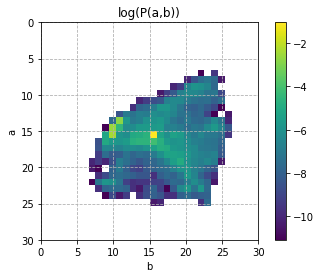

In [4]:
prob_ab = histogram / (counter * num_pixels)
print(np.sum(prob_ab))
list_ab = []
for i in range(32):
    for j in range(32):
        if(prob_ab[i,j] > 0.0):
            list_ab.append((i/32 * 256 - 128,j/32 * 256 - 128, prob_ab[i,j]))       
grid_ab = np.asarray(list_ab)
print(len(grid_ab))
np.save(output_path_prob+'grid_ab.npy', grid_ab)

plt.imshow(np.log(prob_ab), cmap='viridis', extent = [0 , 30, 30, 0], origin='upper')  #interpolation='nearest'
plt.xlabel('b')
plt.ylabel('a')
plt.title('log(P(a,b))')
plt.colorbar()
plt.grid(linestyle='--')
#plt.imsave(fname=output_path_prob, arr=np.log(prob_ab), cmap='viridis', origin='upper', format='png')
plt.show()

In [5]:
# save training and validation data to numpy-arrays
Xtrain_rgb = np.array(image_resized, dtype=float) / 255
image_resized = []
#Xtrain_rgb = np.random.shuffle(Xtrain_rgb)
np.save(output_path_npy+'trainArray.npy', Xtrain_rgb[0:var_num_train_images])
np.save(output_path_npy + 'validArray.npy', Xtrain_rgb[var_num_train_images:])



In [6]:
##############################################################
# select random subset of training images for validation
##############################################################
files = os.listdir(output_path_images)
random_files = np.random.choice(files, var_num_train_images,replace=False)
#random_files = np.random.choice(files, 1)
# move files to validation folder
print('number of files for training: ', len(random_files))
for file in random_files:
    shutil.move(output_path_images + file, output_path_train)
files = os.listdir(output_path_images)
print('number of files for validation: ', len(files))
for file in files:
    shutil.move(output_path_images + file, output_path_valid)
# check number of files per folder
files = os.listdir(output_path_train)
print(output_path_train)
print(len(files))
files = os.listdir(output_path_valid)
print(output_path_valid)
print(len(files))
files = os.listdir(output_path_images)
print(output_path_images)
print(len(files))

number of files for training:  1
number of files for validation:  0
C:\Users\d91482\Desktop\code\finalVersion\content\RecolorizationEncDecIResNet/preprocessing/datasets/output/postersLargeMixedResizedPadded/train/
1
C:\Users\d91482\Desktop\code\finalVersion\content\RecolorizationEncDecIResNet/preprocessing/datasets/output/postersLargeMixedResizedPadded/valid/
1
C:\Users\d91482\Desktop\code\finalVersion\content\RecolorizationEncDecIResNet/preprocessing/datasets/output/postersLargeMixedResizedPadded/images/
0
